In [3]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats
import types

In [4]:
STORAGE_PATH = "../../persisted_data/feather/{}.feather"

def load_data_set(name):
    data = pd.read_feather(STORAGE_PATH.format(name))
    return data

In [5]:
# get some data sets
ibm = load_data_set("IBM_normalized")
jnj = load_data_set("JNJ_normalized")
nasdaq = load_data_set("nasdaq100_10spy_30shift_normalized")
all_stocks = load_data_set("all_stocks_10spy_50shift_normalized")

In [20]:
# simple function used to plot a distribution of values using a histogram
def plot_distribution(y_values, xlabel="future price in relation to current price", ylabel="density", range=[-3,3]):
    size = len(y_values)
    n_bins = min(int(size / 10), 100)
    plt.figure(figsize=(10, 5))
    plt.hist(y_values, bins=n_bins, range=range, density=True)
    sns.kdeplot(y_values, clip=range)
    plt.axvline(y_values.mean(), color="red", linestyle="dashed")
    plt.tight_layout()
    plt.title("Probability density distribution plot with sample size {}".format(size))
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

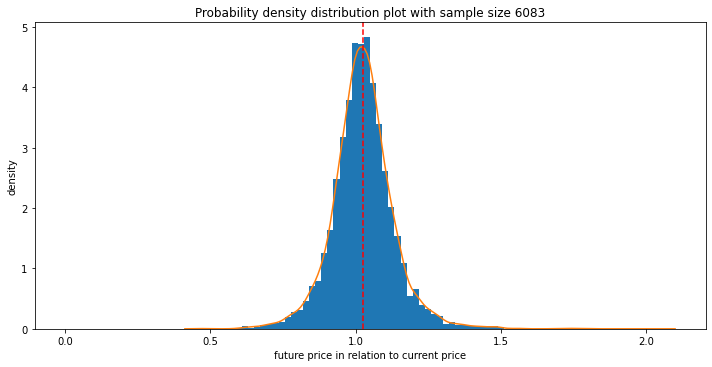

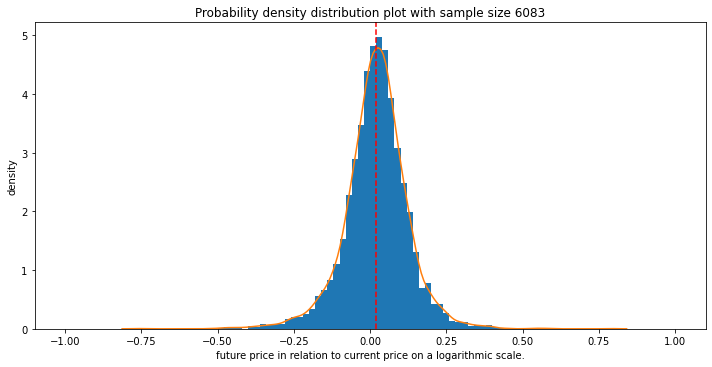

In [23]:
# show difference in the distribution of future prices with and without taking the log
plot_distribution(nasdaq["future_price"], range=[0, 2.1])
plot_distribution(np.log((nasdaq["future_price"])), xlabel="future price in relation to current price on a logarithmic scale.", range=[-1, 1])

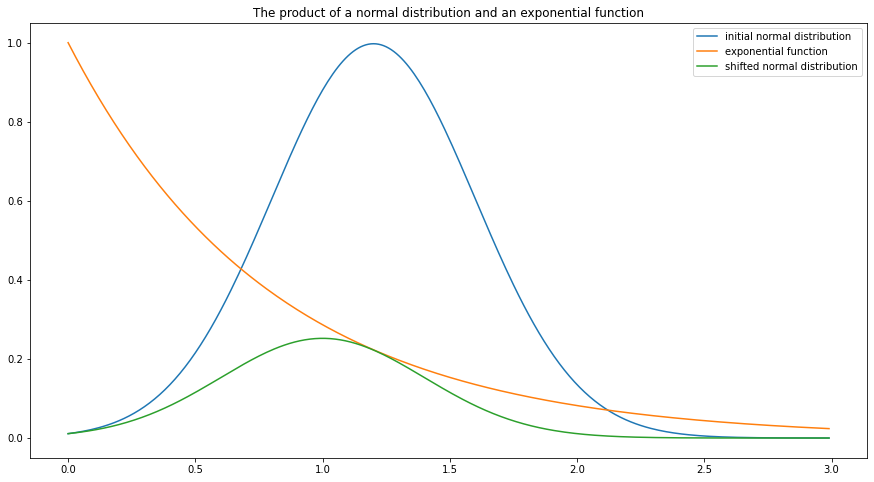

In [8]:
# this function demonstrates the functionality used in data_set_modifier to change the mean of a normal distribution
# a log normal distribution can be shifted the same way, the log has to be taken before this process
def shift_normal(mean=1.1, new_mean=1, std=0.4):
    x = np.arange(0, 3, .01)
    factor = np.exp(-(np.power(mean, 2) - np.power(new_mean, 2)) / (2 * np.power(std, 2)))
    f = factor * np.exp((np.power(x - mean, 2) - np.power(x - new_mean, 2)) / (2 * np.power(std, 2)))
    norm = stats.norm.pdf(x, mean, std)
    plt.figure(figsize=(15, 8))
    plt.title("The product of a normal distribution and an exponential function")
    plt.plot(x, norm)
    plt.plot(x, f)
    plt.plot(x, f * norm)
    plt.legend(["initial normal distribution", "exponential function", "shifted normal distribution"])
    plt.show()
    
# show example functions used in the operation
shift_normal(1.2, 1)

In [9]:
# the mean of a feature is usually not 1
# with this function the distribution of a value in a set of samples can be shifted, by removing some samples
def move_dataset_to_mean(samples, desired_mean=0, feature="future_price", transform=lambda x: np.log, start_of_deletions=np.min):
    # we want to shift a log normal distribution
    # to simplify this process we take the logarithm and treat the distribution as a normal distribution from now on
    y = transform(samples[feature])

    # calculate the characteristic values of the normal distribution
    mean = np.mean(y)
    std = np.std(y)
    
    # define a "start" of the exponential function by setting the point where the keep probability should be = 1
    start = start_of_deletions(y) if isinstance(start_of_deletions, types.LambdaType) else start_of_deletions
    
    # define the probability distribution which is used to shift the sample distribution
    keep_probability = lambda x: np.exp(
        (np.power(x - start - mean, 2) - np.power(x - start - desired_mean, 2)) / (2 * np.power(std, 2))
    )

    # create a set of random numbers between 0 and 1
    random_sample = np.random.random_sample(len(samples))
    # define which samples will be kept
    keep = random_sample < keep_probability(y)
    return samples[keep]

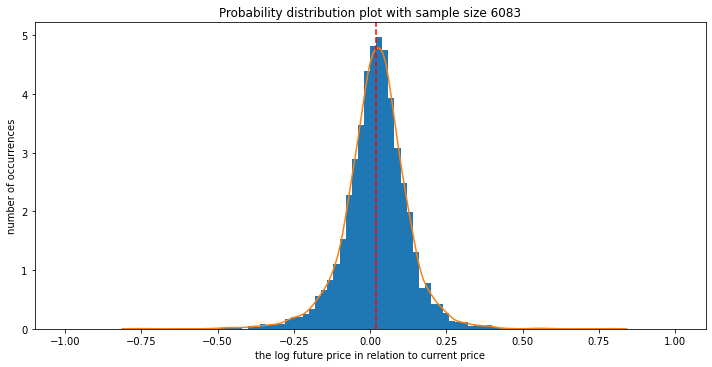

original number of samples: 6083, log mean: 0.020312618754336854, std: 0.10397078369075115


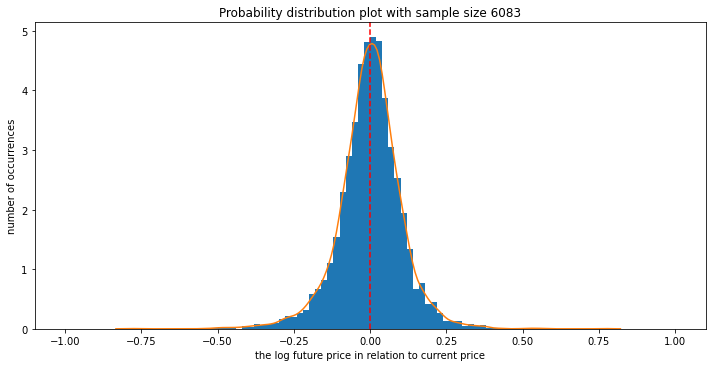

original number of samples: 6083, log mean: 3.3582284486442348e-18, std: 0.10397078369075115


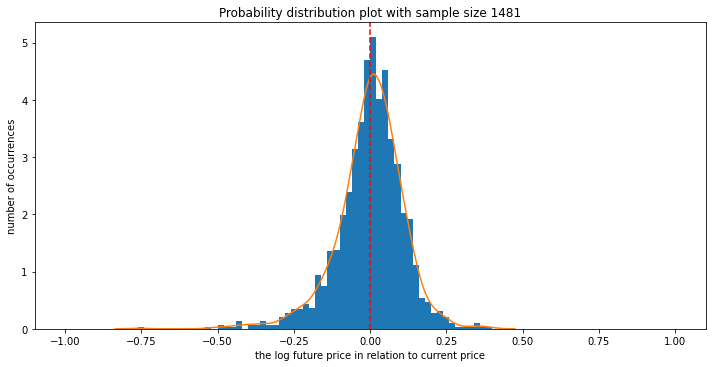

modified number of samples: 1481, log mean: -0.00035079937051880986, std: 0.11069160032335361


In [10]:
# choose a data set
samples = nasdaq

# plot the original future price distribution
samples_mean = np.mean(np.log(samples["future_price"]))
samples_std = np.std(np.log(samples["future_price"]))
plot_distribution(np.log(samples["future_price"]), "the log future price in relation to current price", range=[-1, 1])
print("original number of samples: {}, log mean: {}, std: {}".format(len(samples), samples_mean, samples_std))

# manipulate samples
manipulated = samples.copy()
manipulated["future_price"] = np.exp(np.log(manipulated["future_price"]) - np.mean(np.log(samples["future_price"])))
manipulated_mean = np.mean(np.log(manipulated["future_price"]))
manipulated_std = np.std(np.log(manipulated["future_price"]))

plot_distribution(np.log(manipulated["future_price"]), "the log future price in relation to current price", range=[-1, 1])
print("original number of samples: {}, log mean: {}, std: {}".format(len(manipulated), manipulated_mean, manipulated_std))

# take out samples
reduced = move_dataset_to_mean(samples, transform=np.log, desired_mean=0, start_of_deletions=np.min)

# plot new data set distribution
reduced_mean = np.mean(np.log(reduced["future_price"]))
reduced_std = np.std(np.log(reduced["future_price"]))
plot_distribution(np.log(reduced["future_price"]), "the log future price in relation to current price", range=[-1, 1])
print("modified number of samples: {}, log mean: {}, std: {}".format(len(reduced), reduced_mean, reduced_std))

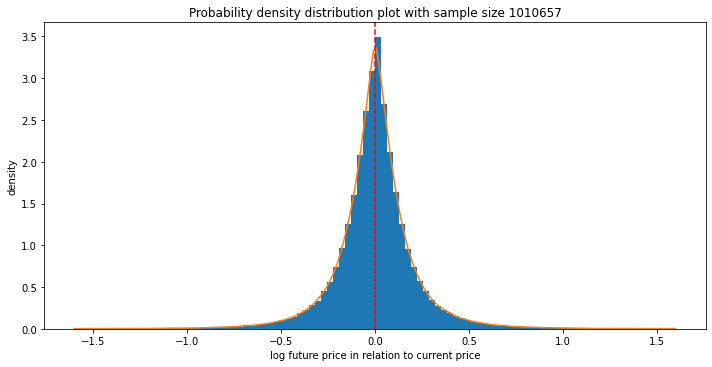

number of samples: 1010657, average: 0.00021682861026033756, std: 0.24134662350471184


In [22]:
# plot distribution of all stock data
all_stocks_mean = np.mean(np.log(all_stocks["future_price"]))
all_stocks_std = np.std(np.log(all_stocks["future_price"]))
plot_distribution(np.log(all_stocks["future_price"]), "log future price in relation to current price", range=[-1.6, 1.6])
print("number of samples: {}, average: {}, std: {}".format(len(all_stocks), all_stocks_mean, all_stocks_std))